In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [16]:
df = pd.read_csv('../Data/02_processed/products_prepared.csv')

In [17]:
df.head(5)

,id,product_name,brands,categories,labels,countries_en,ingredients_text,allergens_0,allergens_1,allergens_2,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits_vegetables_nuts,nutrition_score,glycemic-index_100g
0,140,Pack de 2 twix,Twix,NaN,NaN,France,NaN,NaN,NaN,NaN,...,77.08,NaN,6.2,6.25,NaN,NaN,NaN,NaN,NaN,NaN
1,185,Root beer,A&w,"Boissons,boissons gazeuses,sodas,boissons sucr...","Kascher,contient des ogm",France,"Eau gazéifiée, sirop de maïs à haute teneur en...",NaN,NaN,NaN,...,14.20,13.6,0.0,0.00,0.0616,0.024200,NaN,NaN,18.0,NaN
2,189,"Gotta-have grape, seriously strawberry flavor",Nerds,"Snacks sucrés,confiseries,bonbons","Sans arômes artificiels,contient des ogm",France,NaN,NaN,NaN,NaN,...,93.30,93.3,NaN,0.00,0.0000,0.000000,NaN,NaN,14.0,NaN
3,190,Thé noir aromatisé violette et fleurs,Alice délice,En:beverages,NaN,France,Thé noir aromatisé à la fleur de violette et p...,NaN,NaN,NaN,...,0.10,0.1,NaN,0.10,0.0010,0.000394,NaN,NaN,2.0,NaN
4,193,Preparation mug cake chocolat-caramel au beurr...,Alice délice,NaN,NaN,France,"Farine de blé (gluten), sucre de canne, pépite...",NaN,NaN,NaN,...,70.00,42.0,0.0,7.00,0.9750,0.383858,NaN,NaN,21.0,NaN


## Exploratory Data Analysis

In [18]:
df['brands'] = df['brands'].astype('str')
df['product_name'] = df['product_name'].astype('str')

In [19]:
brands_corpus = ' '.join(df['brands'])
products_corpus = ' '.join(df['product_name'])

In [20]:
# define french stopwords
stops = "alors au aucuns aussi autre avant avec avoir bon car ce cela ces ceux chaque ci comme comment dans des du dedans dehors depuis devrait doit donc dos début elle elles en encore essai est et eu fait faites fois font hors ici il ils je juste la le les leur là ma maintenant mais mes mien moins mon mot même ni nommés notre nous ou où par parce pas peut peu plupart pour pourquoi quand que quel quelle quelles quels qui sa sans ses seulement si sien son sont sous soyez sujet sur ta tandis tellement tels tes ton tous tout trop très tu voient vont votre vous vu ça étaient état étions été être de à aux g mg".split(" ")

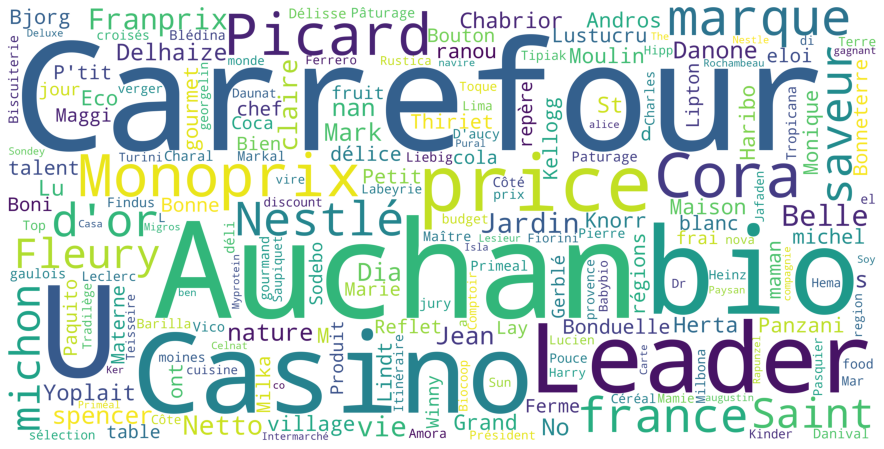

In [21]:
brands_wordcloud = WordCloud(stopwords = stops, background_color = 'white', collocations=False, height = 2000, width = 4000).generate(brands_corpus)
plt.figure(figsize = (16,8))
plt.imshow(brands_wordcloud)
plt.axis('off')
plt.show()

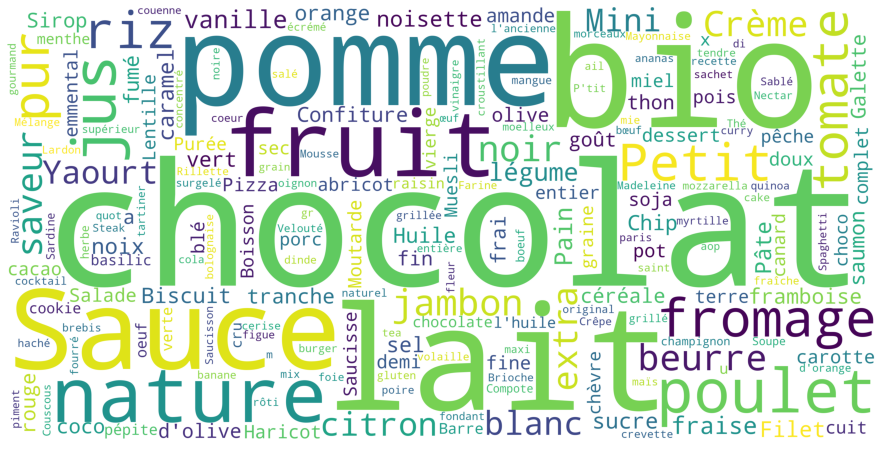

In [22]:
products_wordcloud = WordCloud(stopwords = stops, background_color = 'white', collocations=False, height = 2000, width = 4000).generate(products_corpus)
plt.figure(figsize = (16,8))
plt.imshow(products_wordcloud)
plt.axis('off')
plt.show()

In [23]:
df['content'] = df[['brands', 'product_name']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

In [24]:
df['content'].fillna('Null', inplace = True)

## Training recommander

In [25]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = stops)
tfidf_matrix = tf.fit_transform(df['content'])

In [1]:
input_matrix = tf.transform(["caramel"])
cosine_similarities = linear_kernel(input_matrix, tfidf_matrix)

NameError: name 'tf' is not defined

In [53]:
results = {}
similar_indices = cosine_similarities[0].argsort()[-10:-1]
similar_items = [(cosine_similarities[0][i], df['id'][i], df['product_name'][i]) for i in similar_indices]

In [54]:
print(similar_items)

[(0.3512750528514195, 231299, 'Moelleux chocolat et chocolat blanc'), (0.3574465352798252, 270196, 'Chocolat au lait et aux noisettes'), (0.3599877627191563, 266225, 'Chocolat'), (0.36103810257800467, 218789, 'Cookies goût chocolat et pépites de chocolat'), (0.3638023584218875, 265707, 'Crème dessert aux 3 chocolats chocolat lait, chocolat, et chocolat noir extra.'), (0.37950588824016895, 256190, 'Chocolat'), (0.380172517756983, 253924, 'Chocolat au lait guimauve'), (0.3840706000625737, 227424, 'Crème glacée chocolat, sauce chocolat et éclats de chocolat'), (0.39835731674237085, 221025, 'Chocolat blanc')]
